In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, regexp_replace
from pyspark.ml.feature import MinMaxScaler, VectorAssembler


spark = SparkSession.builder.getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/11/25 00:08:53 WARN Utils: Your hostname, Kiko resolves to a loopback address: 127.0.1.1; using 172.24.205.167 instead (on interface eth0)
24/11/25 00:08:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 00:08:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Import Data into SPARK Data Frame

In [2]:
metadata = spark.read.csv('metadata.csv', header=True) #Enabling header solves issue of the _c0...n header names

In [3]:
metadata.show()

+----------+----+-------+---------+--------------+------------+-------------+-----------+--------+------------+----------+-------+-----+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------+------+------+------+------+------+
| Sample_ID|Year|Country|Continent|Beta.lactamase|Azithromycin|Ciprofloxacin|Ceftriaxone|Cefixime|Tetracycline|Penicillin|NG_MAST|Group|azm_mic|cip_mic|cro_mic|cfx_mic|tet_mic|pen_mic|log2_azm_mic|log2_cip_mic|log2_cro_mic|log2_cfx_mic|log2_tet_mic|log2_pen_mic|azm_sr|cip_sr|cro_sr|cfx_sr|tet_sr|pen_sr|
+----------+----+-------+---------+--------------+------------+-------------+-----------+--------+------------+----------+-------+-----+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------+------+------+------+------+------+
|ERR1549286|2015|     UK|   Europe|          NULL|        >256|         NULL|      0.

24/11/25 00:08:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Preprocessing and Cleaning with Spark

We selected a subset of 9 main preprocessing and cleaning steps that were signifigant.
Then we had to add a series of fixes and patches to get the data in the form that Spark expects. 

In [4]:
from pyspark.sql.functions import skewness
#https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html


#1 Rename invalid column name, Beta Lact.
metadata = metadata.withColumnRenamed("Beta.lactamase", "Beta_lactamase")

#2 Fill NaN values with 0.0 for specific columns - This is because these are our labels and we will just assume that missing data is a negative because negatives are signifigantly more common
metadata = metadata.fillna({"azm_sr": 0.0, "cfx_sr": 0.0, "cip_sr": 0.0})

#3 Drop unnecessary labels - Year has little bearing, thus we drop it. The rest are labels we have no interest in using
useless_columns = ["Year", "cro_sr", "tet_sr", "pen_sr"]
metadata = metadata.drop(*useless_columns)

#4 Dropping Duplicate
metadata = metadata.dropDuplicates()

#5 Remove symbols from string columns
def remove_symbols_from_column(df):
    #Get collection of string fields
    string_columns = [field.name for field in df.schema.fields if field.dataType == "StringType"]

    for col_name in string_columns:
        #Straight up remove symbols
        df = df.withColumn(col_name, regexp_replace(col(col_name), r"[^a-zA-Z0-9]", ""))
    return df

metadata = remove_symbols_from_column(metadata)

#6 Convert specified columns to the appropriate numeric type (float)
numeric_columns = [
    'Azithromycin', 'Ciprofloxacin', 'Ceftriaxone', 'Cefixime', 
    'Tetracycline', 'Penicillin', 
    'NG_MAST', 'Group', 'azm_mic', 'cip_mic', 'cro_mic', 'cfx_mic', 'tet_mic', 'pen_mic', 
    'log2_azm_mic', 'log2_cip_mic', 'log2_cro_mic', 'log2_cfx_mic', 'log2_tet_mic', 'log2_pen_mic'
]

for column in numeric_columns:
    metadata = metadata.withColumn(column, col(column).cast("float"))


#7 Just splitting for what comes next
train_inputs, test_inputs = metadata.randomSplit([0.8, 0.2], seed=69)

#8 Select the columns we determined to be the most impactful during our EDA steps. Also includes needed columns. This step also drops Sample_ID
best_columns = ['Group', 'azm_mic', 'log2_azm_mic', 'log2_cip_mic', 'cip_mic', 'cro_mic', 
    'cfx_mic', 'log2_cro_mic', 'log2_cfx_mic', 'Ciprofloxacin', 'Cefixime', 
    'Tetracycline', 'Penicillin', 'log2_tet_mic', 'log2_pen_mic', 'azm_sr'
]


#9 Impute Nulls - Ditched skew based for complexity reasons
def impute_nulls(df, columns):

    for column_name in columns:

        impute_value = df.select(mean(col(column_name))).collect()[0][0]
        
        #Impute null values with the calced value
        df = df.withColumn(column_name, when(col(column_name).isNull(), impute_value).otherwise(col(column_name)))
    return df

train_inputs = impute_nulls(train_inputs, numeric_columns)
test_inputs = impute_nulls(test_inputs, numeric_columns)


#==========================================================================================================
#The mess begins below


#Prepare data for modeling
#Effectively the squeeze from before but will try to use vector assembler https://spark.apache.org/docs/3.4.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html
#https://spark.apache.org/docs/latest/ml-features.html#vectorassembler
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.select.html
feature_cols = [col for col in best_columns if col not in ['azm_sr']]
vec_asm_out = VectorAssembler(inputCols=feature_cols, outputCol="features")

#Transform data to include feature vectors
train_data = vec_asm_out.transform(train_inputs).select("features", col("azm_sr").alias("label"))
test_data = vec_asm_out.transform(test_inputs).select("features", col("azm_sr").alias("label"))

#FIXES BELOW

#Models gave error not liking negatives so we need to scale
scaler = MinMaxScaler(inputCol="features", outputCol="scaled")
scaler_model = scaler.fit(train_data)

train_data = scaler_model.transform(train_data).select("scaled", col("label"))
test_data = scaler_model.transform(test_data).select("scaled", col("label"))

train_data = train_data.withColumnRenamed("scaled", "features")
test_data = test_data.withColumnRenamed("scaled", "features")

#Edit 1: To fix error that labels were strings and not floats
#Edit 2: Fix error that labels were floats and not ints
train_data = train_data.withColumn("label", col("label").cast("int"))
test_data = test_data.withColumn("label", col("label").cast("int"))


#Take care of magic nulls that somehow arent present in the DF but are present in the vector
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.when.html
train_data = train_data.withColumn("label", when(col("label").isNull(), 0).otherwise(col("label")))
test_data = test_data.withColumn("label", when(col("label").isNull(), 0).otherwise(col("label")))





In [5]:
train_inputs.show()
print(train_data)

+----------+---------------+---------+--------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+-----+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+------+------+
| Sample_ID|        Country|Continent|Beta_lactamase|       Azithromycin|       Ciprofloxacin|         Ceftriaxone|            Cefixime|      Tetracycline|         Penicillin|           NG_MAST|Group|            azm_mic|             cip_mic|             cro_mic|             cfx_mic|           tet_mic|            pen_mic|        log2_azm_mic|       log2_cip_mic|       log2_cro_mic|       log2_cfx_mic|        log2_tet_mic|       log2_pen_mic|azm_sr|cip_sr|cfx_sr|
+----------+---------------+---------+--------------+---------------

### Eval code

Largely inherited from last phase with modifications to convert spark df into pandas df (for eval only)

General Guidelines for ROC Curves and such:

AUC close to 1 -> Very Good \
AUC ~ 0.5 -> Like random guessing \
AUC < 0.5 -> Really bad

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd



#Plot ROC Curve
def plot_roc_curve(y_test, y_probs, name):


    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Score: ' + str(name))
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#Eval Classification
def eval_classification(y_test_SPARK, y_pred_SPARK, name):

    #Convert Spark DataFrames to pandas for EVAL ONLY
    y_test = y_test_SPARK.toPandas().squeeze()
    y_pred_probs = y_pred_SPARK.toPandas().squeeze() 

    #Retired old threshold function in favor of simpelr one
    y_pred = (y_pred_probs > 0.5).astype(float) 

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', marker='x')
    plt.yticks([0, 1.0])
    plt.ylim(-0.4, 1.4) #Offsets for prettying. Adjust if your resolution screws someting up
    plt.title('CLASSIFICATION - Predictions vs Ground Truth: ' + str(name))
    plt.ylabel('Super Resistance')
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_roc_curve(y_test, y_pred, name)

    return metrics

In [7]:

train_data.filter(col("label").isNull()).show()
test_data.filter(col("label").isNull()).show()

+--------+-----+
|features|label|
+--------+-----+
+--------+-----+

+--------+-----+
|features|label|
+--------+-----+
+--------+-----+



### ML Section

## 1. Naive Bayes

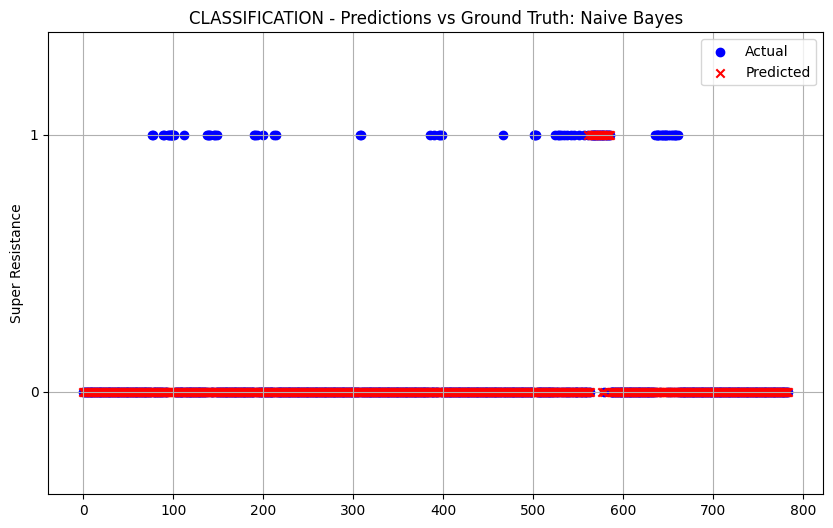

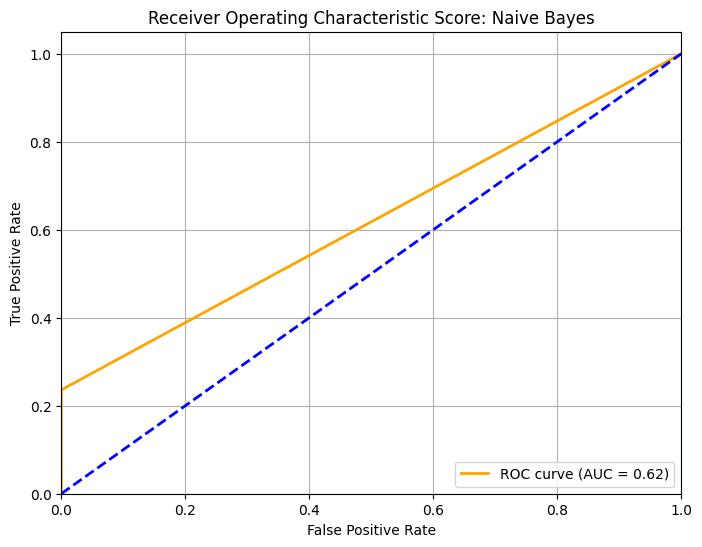

{'Accuracy': 0.9132653061224489, 'Precision': np.float64(0.9209952657340787), 'Recall': np.float64(0.9132653061224489), 'F1 Score': np.float64(0.8884790204896026)}


In [8]:
from pyspark.ml.classification import NaiveBayes

def naive_bayes_spark(train_data, test_data):

    model = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")
    model = model.fit(train_data)
    
    predictions = model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")

    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "Naive Bayes")
    print(metrics)

naive_bayes_spark(train_data, test_data)

## 2. Logistic Regression

Same as before, 10 iterations for consistency

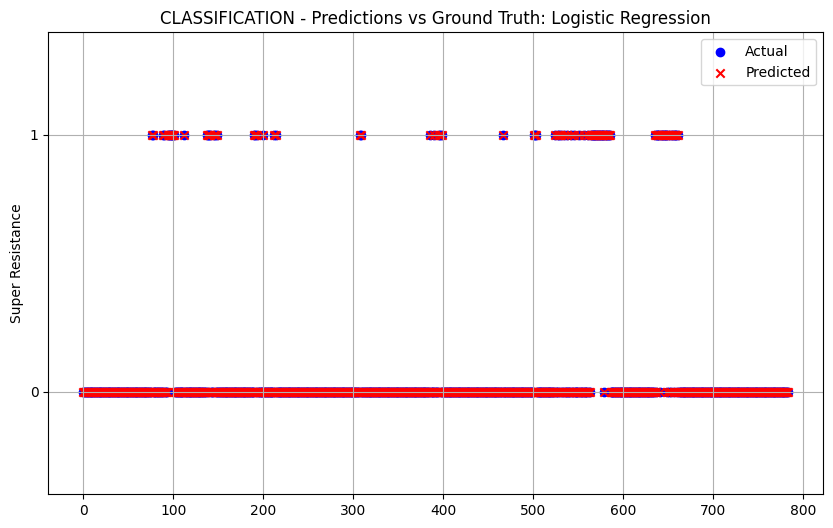

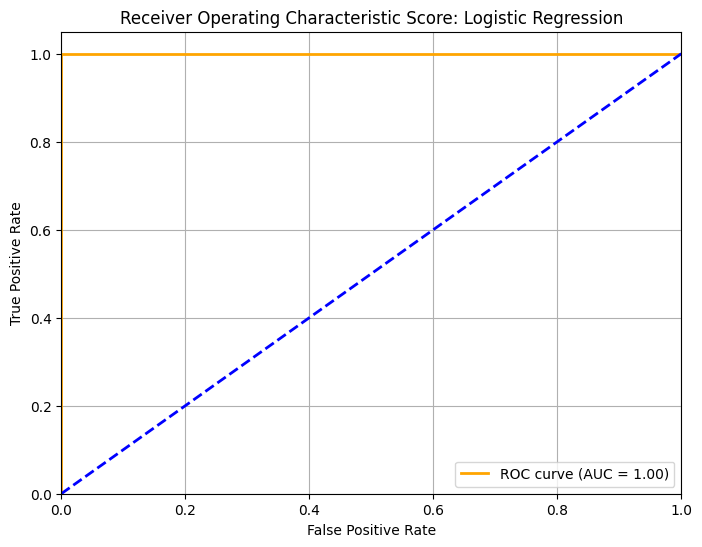

{'Accuracy': 1.0, 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1 Score': np.float64(1.0)}


In [9]:
from pyspark.ml.classification import LogisticRegression

def logistic_regression_spark(train_data, test_data):


    model = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction",  maxIter=10)
    model = model.fit(train_data)
    
    predictions = model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")


    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "Logistic Regression")
    print(metrics)

logistic_regression_spark(train_data, test_data)

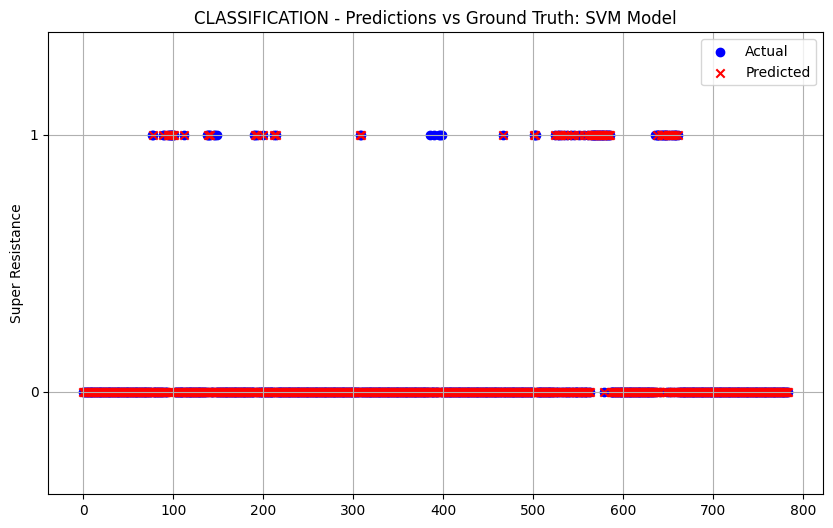

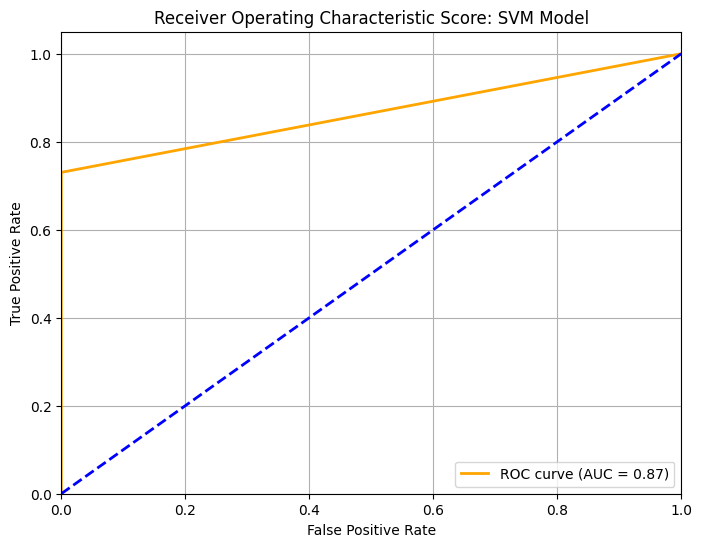

{'Accuracy': 0.9693877551020408, 'Precision': np.float64(0.9704095824699839), 'Recall': np.float64(0.9693877551020408), 'F1 Score': np.float64(0.967262178112855)}


In [10]:
from pyspark.ml.classification import LinearSVC

def SVM_model_spark():
    svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1)
    svm_model = svm.fit(train_data)

    predictions = svm_model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")

    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "SVM Model")
    print(metrics)
    
SVM_model_spark()

In [14]:
print(train_data.select('label').head(20))

[Row(label=1), Row(label=1), Row(label=1), Row(label=1), Row(label=1), Row(label=1), Row(label=1), Row(label=1), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=1)]


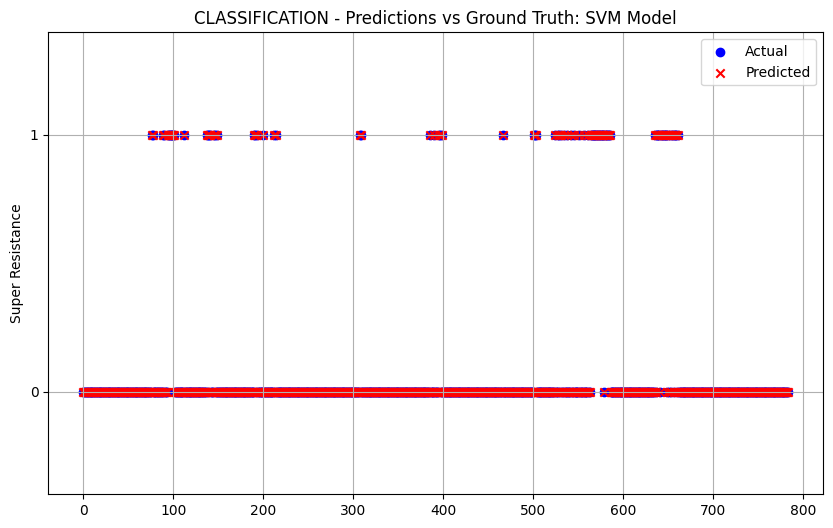

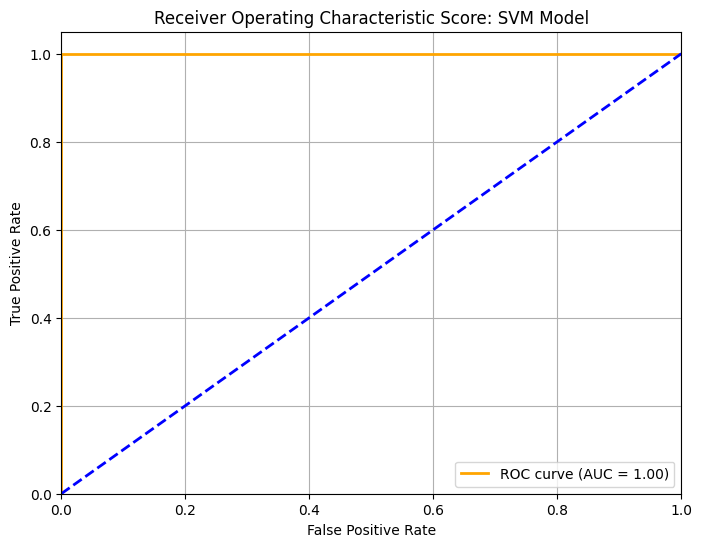

{'Accuracy': 1.0, 'Precision': np.float64(1.0), 'Recall': np.float64(1.0), 'F1 Score': np.float64(1.0)}


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

def neural_network():
    layers = [
    len(feature_cols),
        8,                     
        4,                     
        2                   
    ]
    mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers=layers, maxIter=10)

    mlp_model = mlp.fit(train_data)

    predictions = mlp_model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")

    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "Neural Network")
    print(metrics)

neural_network()


In [ ]:
spark.stop()